In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("autosavetime/main")
utils.load_extension("execute_time/ExecuteTime")

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('../')

In [22]:
import pandas as pd
import random
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from utils.cern_utils import plot_feature_importance
from sklearn.metrics import roc_auc_score,auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
plt.style.use('seaborn')

In [23]:
random.seed(42)
np.random.seed(42)

In [4]:
train = pd.read_csv("../data/train.csv", index_col="Id")
test = pd.read_csv("../data/test.csv", index_col="Id")
train = train.drop(columns="BUTTER")
test = test.drop(columns="BUTTER")

In [24]:
X_tr, X_te, y_tr, y_te = train_test_split(
    train.drop(columns="signal"), train.signal, stratify=train.signal,#train_size=0.99
)

In [25]:
X_te.shape

(53166, 14)

In [26]:
X_tr.shape

(159496, 14)

## Catboost

In [27]:
cb = CatBoostClassifier(verbose=0, eval_metric="AUC")
cb.fit(X_tr, y_tr)

In [28]:
print("train", roc_auc_score(y_tr.values,cb.predict_proba(X_tr)[:,1]))
print("test", roc_auc_score( y_te,cb.predict_proba(X_te)[:,1]))

train 0.8995608627975153
test 0.8675951508168744


14 features, reduction of 0.00%


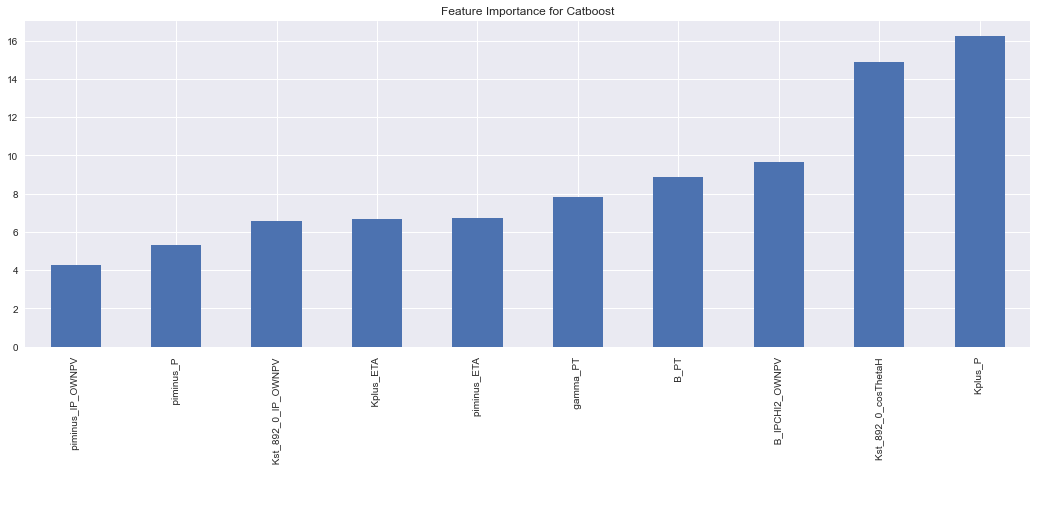

In [29]:
plot_feature_importance(X_tr.columns,cb.get_feature_importance())

## Xgb

In [11]:
xgb = XGBClassifier()
xgb.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
print("train", roc_auc_score(y_tr.values,xgb.predict_proba(X_tr)[:,1]))
print("test", roc_auc_score( y_te,xgb.predict_proba(X_te)[:,1]))

train 0.9034595997623317
test 0.8615016787619687


## Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_tr,y_tr)

RandomForestClassifier(n_estimators=50)

In [14]:
print("train", roc_auc_score(y_tr.values,rf.predict_proba(X_tr)[:,1]))
print("test", roc_auc_score( y_te,rf.predict_proba(X_te)[:,1]))

train 0.9999999807378462
test 0.834049833105394


## Voting Classifier

In [15]:
vc = VotingClassifier(estimators=[("cb", cb), ("xgb", xgb), ("rf", rf)], voting="soft")

In [16]:
vc.fit(X_tr, y_tr)

VotingClassifier(estimators=[('cb',
                              <catboost.core.CatBoostClassifier object at 0x123ccceb8>),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                         

In [17]:
print("train", roc_auc_score(y_tr.values,vc.predict_proba(X_tr)[:,1]))
print("test", roc_auc_score( y_te,vc.predict_proba(X_te)[:,1]))

train 0.9776557968728543
test 0.8645498195043498


## Own Ensemble

## Submission

In [18]:
test['Predicted'] = cb.predict_proba(test)[:,1]

In [20]:
test[['Predicted']].to_csv('../submissions/initial_subm_proba.csv')